In [4]:
import numpy as np
from matplotlib import pyplot as plt 
from matplotlib import animation as am
from matplotlib import cm
from kuramoto import * # import the kuramoto classes from file 
from utils import *
from scipy.optimize import root_scalar, minimize, brute

## First, we do some 1D simulations.  

In [20]:
# Set up model parameters 
epsilon = 1
etas = [-1, -0.5, -0.6]
sigma = 0.7
mean_omega = 0
alpha = 0.214


# Set up simulation parameters 
L = 200
T = 1e4 # total time of the simulation 
n_frames = 1e4 # number of time points recorded in the end 
grad = 1.3
grads = [-grad, grad]

In [21]:
data = [] 
omegas = [] 
rhs = [] 
seed = 30


for (i, eta) in enumerate(etas): 
    # Initialise the model and run the simulation 
    init = np.zeros(L)
    model = KuramotoNNN(epsilon, eta, sigma, mean_omega, alpha, BC='grad', grad=grads)
    model.initialise(L, T, n_frames, init=init, seed=seed) 
    model.evolve() # this runs the simulation, set verbose to True to see output at every time step 
    
    phases = np.copy(model.res[-1]) % (2*np.pi)
    shift(phases)
    data.append(phases)
    omegas.append(model.omegas)
    rhs.append(model._det_rhs(phases))

100%|█████████████████████████████████████| 10000/10000 [02:18<00:00, 72.25it/s]


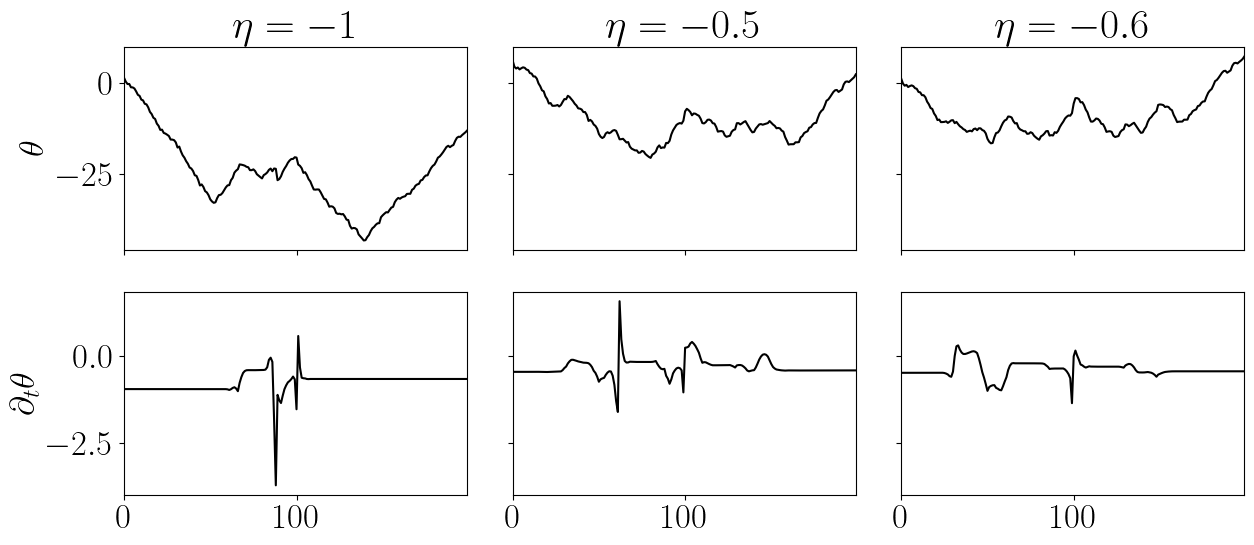

In [22]:
f = len(etas)

plt.rc('text', usetex=True)
plt.rc('font', size=25, family='serif')
fig, axes = plt.subplots(2, len(etas[:f]), sharey='row', sharex=True, figsize=(4*len(etas[:f])+1, 6))

for (i, eta) in enumerate(etas[:f]):
    axes[0, i].plot(data[i], 'k-')    
    axes[1, i].plot(rhs[i], 'k-')
    axes[0, i].set_title(r'$\eta={}$'.format(etas[i]))
    

axes[0, 0].set_ylabel(r'$\theta$')
axes[1, 0].set_ylabel(r'$\partial_t \theta $')
plt.xlim([0, L-1])
plt.tight_layout()
plt.show() 

In [23]:
def MAP(phi): 
    f = lambda x: cost(phi, x[0], x[1], x[2]) 
    bounds = ((-1, 1), (-np.pi, np.pi), (0, 1))
    res = minimize(f, (-1, 0, 0), method='trust-constr', bounds=bounds)
    
    # brute(f, ((-1, 0), (-np.pi, np.pi), (0, 1)))
    return res

def get_MAP_sigma(phi, eta, grad, alpha):
    L = len(phi)+1
    phi = np.concatenate([[-grad], phi, [grad]])
    phi2 = phi[1:] + phi[:-1] 
    phi2 = np.concatenate([[-2*grad], phi2, [grad*2]])
    
    rhs = get_rhs(phi, phi2, eta, alpha) 
    overall_freq = np.sum(rhs)/L
    omegas = (rhs - overall_freq)[:-1]

    Cov = get_cov(L)
    invCov = np.linalg.inv(Cov)
    var = (omegas.T @ invCov @ omegas)/(L-1)
    return np.sqrt(var) 

def cost(phi, eta, grad, alpha): 
    L = len(phi)+1
    phi = np.concatenate([[-grad], phi, [grad]])
    phi2 = phi[1:] + phi[:-1] 
    phi2 = np.concatenate([[-2*grad], phi2, [grad*2]])
    
    rhs = get_rhs(phi, phi2, eta, alpha) 
    overall_freq = np.sum(rhs)/L
    omegas = (rhs - overall_freq)[:-1]

    Cov = get_cov(L)
    invCov = np.linalg.inv(Cov)
    var = (omegas.T @ invCov @ omegas)/(L-1)
    
    J = get_J(phi, phi2, eta, alpha)
    logdetJ = np.log(np.abs(np.linalg.det(J))) 
    
    logpdf = stats.multivariate_normal.logpdf(omegas, cov=Cov*var)

    return - logpdf - logdetJ

def get_cov(L): 
    cov = np.identity(L-1) 
    cov -= 1/L
    return cov 

def get_rhs(phi, phi2, eta, alpha): 
    NN = np.sin(phi[1:]) - np.sin(phi[:-1]) + eta*(2-np.cos(phi[1:])-np.cos(phi[:-1]))
    NNN = np.sin(phi2[2:]) - np.sin(phi2[:-2]) + eta*(2-np.cos(phi2[2:])-np.cos(phi2[:-2]))
    return NN + alpha*NNN   

def get_J(phi, phi2, eta, alpha):
    L = len(phi)-1
    J = np.zeros((L, L))
    diag = np.cos(phi[1:-1]) + eta*np.sin(phi[1:-1]) + alpha*(np.cos(phi2[2:-1])+eta*np.sin(phi2[2:-1]))
    np.fill_diagonal(J, np.append(diag, 0))
    for i in range(L):
        if i >= 1: 
            J[i, i-1] = - np.cos(phi[i]) + eta*np.sin(phi[i])
            J[i, i-1] += alpha*(-np.cos(phi2[i]) + eta*np.sin(phi2[i]))
        if i <= L-2: 
            J[i, i+1] = alpha*(np.cos(phi2[i+2]) + eta*np.sin(phi2[i+2]))
        if i >=2:
            J[i, i-2] = alpha*(-np.cos(phi2[i]) + eta*np.sin(phi2[i]))
    d_omega = np.sum(J, axis=0)/L
    J -= d_omega[np.newaxis, :] 
    return J[:-1, :-1]

In [24]:
for n in range(len(etas)):
    phi = data[n][1:]-data[n][:-1]
    c = cost(phi, etas[n], grad, alpha) 
    print(c)
    res = MAP(phi)
    print(res.x, res.fun)
    etam, gradm, alpham = res.x 
    print(etas[n], grad, alpha)
    print(get_MAP_sigma(phi, etam, gradm, alpham) )

168.34716647148142
[-0.63217207 -0.00098818  0.00105276] 181.64630476806747
-1 1.3 0.214
0.547315837568988
193.76322138480577
[-0.87685397  0.66376954  0.18971342] 194.1240916672758
-0.5 1.3 0.214
0.7459007576306724
191.4258548501245
[-0.58732452  0.79870947  0.29093886] 190.02203534854115
-0.6 1.3 0.214
0.7265044434770491


In [51]:
etas_map = [] 
etas_err_hess = [] 
etas_err_brute = []


for theta in data: 
    phi = theta[1:] - theta[:-1]
    eta, grad, alpha = MAP(phi)
    print(eta, grad, alpha)
    # sigma = get_MAP_sigma(phi, eta, grad)
    # errs_hess = 2*np.array(errors_hess(phi, eta, sigma, grad, diff=1e-4))
    # widths = errs_hess*10
    # widths[-1] = np.pi 
    # widths[0] = 1 
    # errs_brute = errors_brute(phi, eta, sigma, grad, diff=widths)
    # print('eta: ', eta, ', error: ', errs_hess[0], errs_brute[0])
    # print('sigma: ', sigma, ', error: ', errs_hess[1], errs_brute[1])
    # print('grad: ', grad, ', error: ', errs_hess[2], errs_brute[2])
    # plot_cost(phi, eta, sigma, grad, widths=widths)
    
    # etas_map.append(eta)
    # etas_err_hess.append(errs_hess[0])
    # etas_err_brute.append(errs_brute[0]) 

/var/folders/5n/0rvnm9350db7gk5vdnj3tn6h0000gn/T/ipykernel_20800/4212751768.py:59: RuntimeWarning: divide by zero encountered in log
  logdetJ = np.log(np.abs(np.linalg.det(J)))


0.44593432508294734 0.9816856062615554 -0.5085217898352548
-0.1482264526130978 0.9447668739263496 -0.44850855413675805


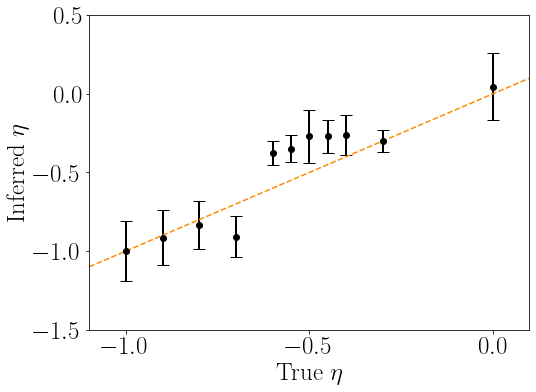

In [15]:
plt.rc('font', size=25, family='serif')
plt.rc('text', usetex=True)

plt.figure(figsize=(8, 6))

plt.errorbar(etas, etas_map, etas_err_brute, fmt='o', linewidth=2, color='k', capsize=6)
plt.plot(np.linspace(-1.1, 0.1, 10), np.linspace(-1.1, 0.1, 10), '--', color='darkorange')
plt.xlabel(r'True $\eta$')
plt.ylabel(r'Inferred $\eta$')
plt.xticks([-1, -0.5, 0])
plt.ylim([-1.5, 0.5])
plt.xlim([-1.1, 0.1])
plt.tight_layout()
plt.savefig('sim_eta.pdf', bbox_inches="tight")
plt.show()
